## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [ ]:
!pip install pennylane qiskit[visualization]

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# import os
import pennylane as qml
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.extensions import Initialize
#from pennylane.templates import RandomLayers
#from pennylane_ionq import ops

'''
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
'''

'\nimport qiskit\nfrom qiskit import transpile, assemble\nfrom qiskit.visualization import *\nfrom qiskit.circuit.random import random_circuit\n\nimport torch\nfrom torch.autograd import Function\nfrom torchvision import datasets, transforms\nimport torch.optim as optim\nimport torch.nn as nn\nimport torch.nn.functional as F\n'

### 1-2. Setting of the main hyper-parameters of the model

In [4]:
BATCH_SIZE = 16
n_qubits = 9
n_params = 90
n_epochs = 100  # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 1280  # Size of the train dataset
n_test = 320    # Size of the test dataset

SAVE_PATH = "aeqis/" # Data saving folder
seed = 2022
np.random.seed(seed)        # Seed for NumPy random number generator

isReal = False # 'True' for real device or 'False' for simulator

## 2. Construct Quantum Circuit

### 2-1. One Qubit Unitary Circuit 

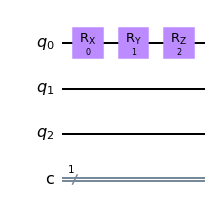

In [3]:
n_qubits = 3
def one_qubit_unitary(params, wire):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '1 Qubit Unitary')

  circ.rx(params[0],wire)
  circ.ry(params[1],wire)
  circ.rz(params[2],wire)
  
  return circ

params = np.arange(0, 3)
one_qubit_unitary(params, 0).draw(output='mpl')

### 2-2. Two Qubits Unitary Circuit

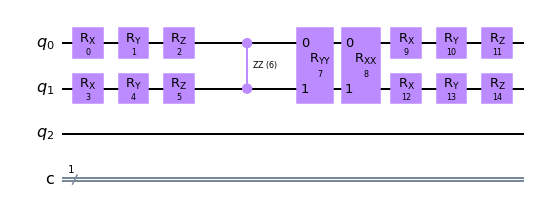

In [4]:
def two_qubit_unitary(params, wires):  # need 15 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '2 Qubit Unitary')
  circ.compose(one_qubit_unitary(params[0:3], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[3:6], wires[1]), inplace=True)
  circ.rzz(params[6], wires[0], wires[1])
  circ.ryy(params[7], wires[0], wires[1])
  circ.rxx(params[8], wires[0], wires[1])
  circ.compose(one_qubit_unitary(params[9:12], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[12:15], wires[1]), inplace=True)
  #circ.barrier()

  return circ

params = np.arange(0, 15)
two_qubit_unitary(params, [0,1]).draw(output='mpl')

### 2-3. Three Qubits Unitary Circuit

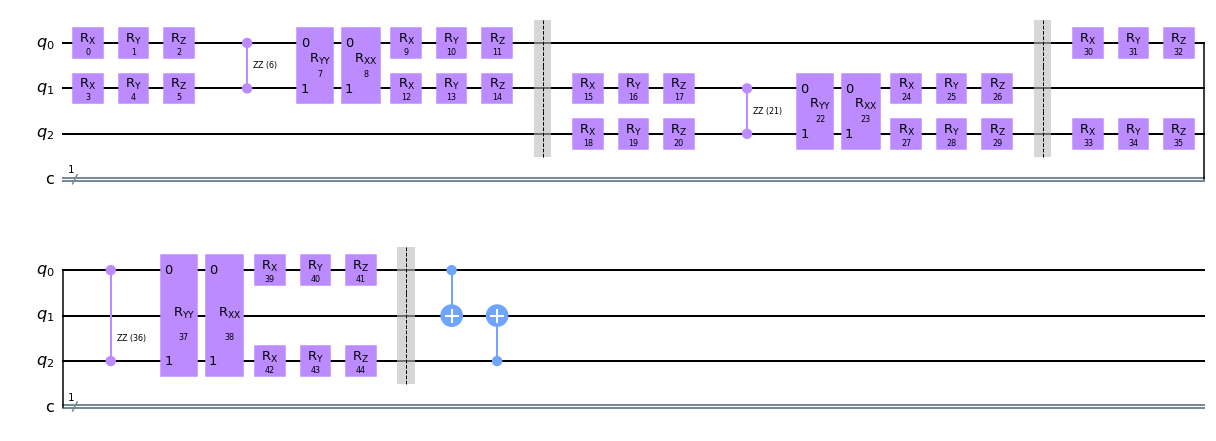

In [7]:
n_qubits = 3
def three_qubit_unitary(params, wires):  # need 45 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '3 Qubit Unitary')
  circ.compose(two_qubit_unitary(params[0:15], [wires[0],wires[1]]), inplace=True)
  circ.barrier()
  circ.compose(two_qubit_unitary(params[15:30], [wires[1],wires[2]]), inplace=True)
  circ.barrier()

  circ.compose(two_qubit_unitary(params[30:45], [wires[0],wires[2]]), inplace=True)
  circ.barrier()

  circ.cx(wires[0], wires[1])
  circ.cx(wires[2], wires[1])

  #circ.measure([wires[0],wires[2]], [0, 0])   
  #circ.barrier()

  return circ

params = np.arange(0, 45)
three_qubit_unitary(params, [0,1,2]).draw(output='mpl')

### 2-4. Decoder Circuit

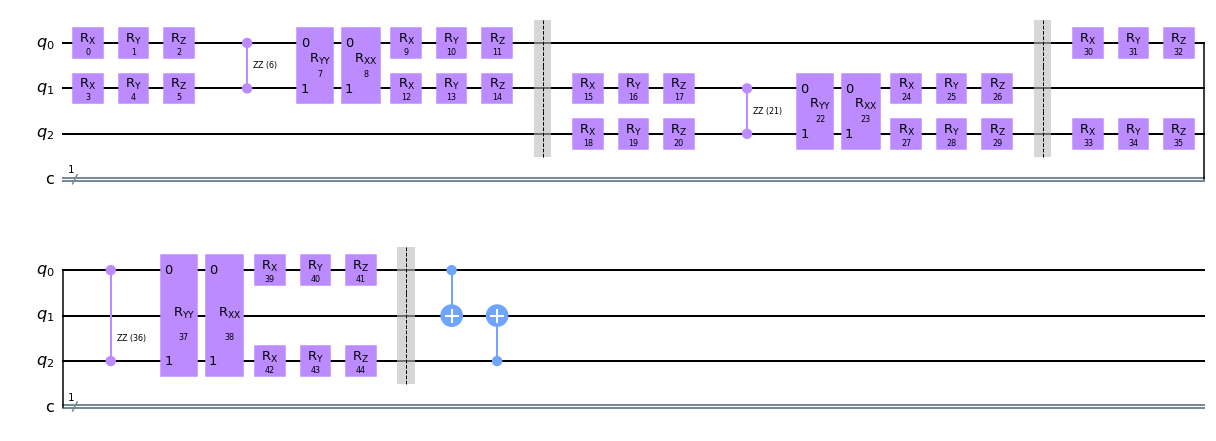

In [9]:
# Defining Decoder circuit.
def decoder(params, wires):  # need 90 parameters
  dec = QuantumCircuit(n_qubits, 1, name = 'Decoder')
  # U1
  dec.compose(three_qubit_unitary(params[0:45], wires[0:3]), inplace=True)

  return dec

params = np.arange(0, 90)
decoder(params, np.arange(0,9)).draw(output='mpl')

### 2-5. Encoder Circuit

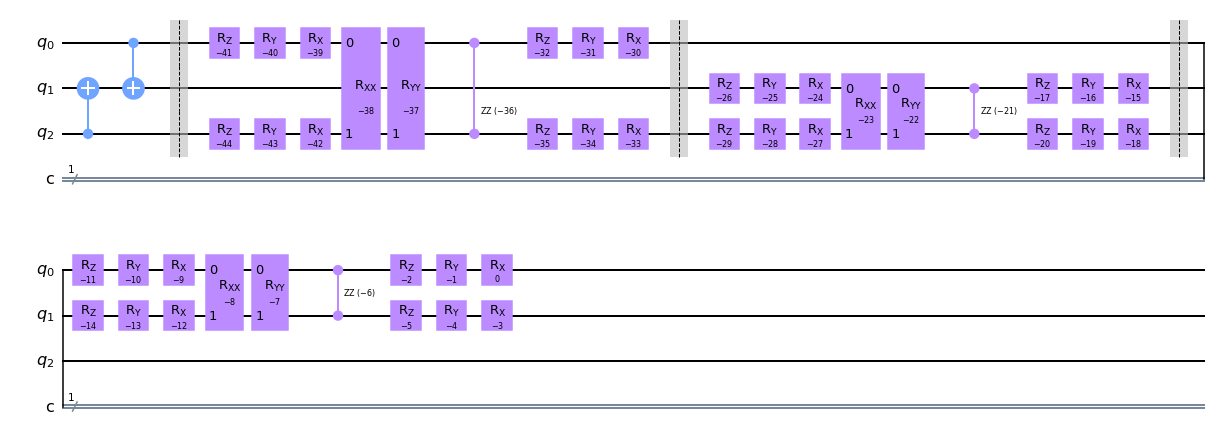

In [10]:
# Defining Encoder circuit. Encoder is inversion of Decoder.
def encoder(decoder):
    enc = QuantumCircuit(n_qubits, 1, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

# visualizing Encoder to check
params = np.arange(0, 90)
encoder(decoder(params, np.arange(0,9))).draw(output='mpl')

### 2-5.1 Noise model

In [68]:
import random
circ = QuantumCircuit(3,1)
x_p = 30
z_p= 30
xz_p = 30

circ = QuantumCircuit(3,1)
def random_circuit(n,circ,x_p,z_p,xz_p):
    circ = QuantumCircuit(3,1)
    p = x_p + z_p + xz_p
    print(f"bit flip 확률:{x_p}%\nphase flip 확률:{z_p}%\nbit and phase flip 확률 :{xz_p}%,\nIdentitiy(non error):{100-p}%")
    
    a = random.choices(range(1, 5),weights=[x_p, z_p, xz_p,100-p ])
    if a ==[1]:
        circ.x(n)
    elif a ==[2]:
        circ.z(n)
    elif a ==[3]:
        circ.x(n)
        circ.z(n)
    elif a ==[4]:
        pass
    return circ
random_circuit(1,circ,x_p,z_p,xz_p).draw()

bit flip 확률:30%
phase flip 확률:30%
bit and phase flip 확률 :30%,
Identitiy(non error):10%


q_0: ─────
     ┌───┐
q_1: ┤ Z ├
     └───┘
q_2: ─────
          
c: 1/═════

### 2-6. Complete Circuit

0 100 0 0


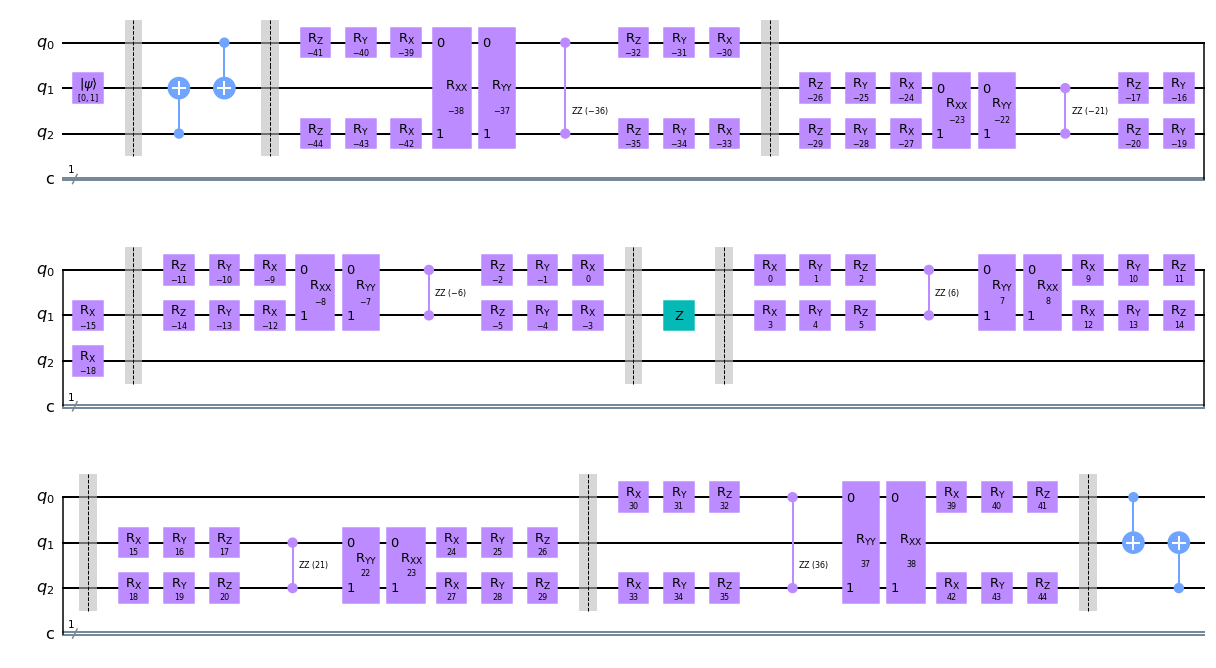

In [59]:
def qae(params, wires, input_state, error_qubit):  # need 90 parameters
  qc = QuantumCircuit(n_qubits, 1, name = 'Quantum Autoencoder')
  qc.append(input_state, [1])
  qc.barrier()

  dec = decoder(params, np.arange(0,3))
  qc.compose(encoder(dec), inplace=True)

  qc.barrier()
  qc.compose(random_circuit(1,qc,x_p,z_p,xz_p),inplace=True)
  qc.barrier()
  qc.compose(dec, inplace=True)

  #qc.barrier()
  #qc.measure(np.arange(0,9), np.arange(0,9)) 

  return qc

params = np.arange(0, 90)
wires = np.arange(0,3)
initial_state = [0, 1]
input_state = Initialize(initial_state)
qae(params, wires, input_state, 1).draw(output='mpl')

## 3. Optimization

### 3-1. Generalize Output State

In [43]:
def gen_states(output_state, target_state):
  alpha = 0
  for i in range(16):
    alpha += np.power([abs(output_state[32*i+j]) for j in range(16)],2)
  alpha = np.sqrt(alpha)

  beta = 0
    
  if alpha == 0:
    for i in range(16):
      beta += np.power([abs(output_state[32*i+16+j]) for j in range(16)], 2)
    beta = np.sqrt(beta)

  else:
    pseudo_alpha = 0
    for i in range(16):
      beta += np.sum([output_state[32*i+16+j] for j in range(16)])
      pseudo_alpha += np.sum([output_state[32*i+j] for j in range(16)])
    beta = beta / pseudo_alpha * alpha
    
  a, b = target_state[0], target_state[1]
  if abs(a) == 0:
    b = abs(b)
  else:
    b = (b / a) * abs(a)
    a = abs(a)
    
  return np.array([alpha, beta]), np.array([a, b])

### 3-2. Choose PennyLane Backend & Create a QNode

In [5]:
if isReal:
  dev = qml.device("qiskit.ibmq", wires=n_qubits)
else:
  dev = qml.device("lightning.qubit", wires=n_qubits)

In [ ]:
# Create a QNode from the paramters
@qml.qnode(dev)
def trainee(params, input_state, error_qubit):
  qml.from_qiskit(qae(params, np.arange(0,9), input_state, error_qubit))
  return qml.state()

### 3-3. Create Cost Function

In [ ]:
def cost(params, input_batch, targets):
  cost = 0
    
  for input_state in input_batch:
    target_state = input_state
    # initialize state
    input_state = Initialize(input_state)
        
    for error_qubit in range(-1, 3):
      # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
      output_state = trainee(params, input_state, error_qubit)
      output_state = np.array(output_state)
      output_state, target_state = gen_states(output_state, target_state)
      # adding cost for single circuit
      cost += np.linalg.norm(output_state - target_state)
      
  # returning total cost
  return cost

In [ ]:
losses = []
accs = []
for epoch in range(10000):
  train_loss = 0
  acc = 0
  for (x_train, y_train) in train_loader:
    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  if epoch%10 == 9:
    if epoch%100 == 99:
      print(epoch+1,train_loss)
    losses.append(train_loss.item())
  if epoch%10 == 9:
    accs.append(acc) 
  del acc

In [ ]:
from matplotlib.pyplot import plot
x = np.arange(0,10000,10)
plot(x,losses)

In [ ]:
x = np.arange(0,10000,10)
plot(x,accs)

In [ ]:
file = pd.DataFrame(data={'train_loss': losses,
                          'train_acc': accs})
file.to_pickle(file_name)